# Analyzing Dutch Tweets for Sentiment Indicating Depression

In [1]:
import json

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea

In [4]:
from datetime import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import set_random_seed
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 
# from tensorflow.keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
# from tensorflow.keras.layers.convolutional import Conv1D
# from tensorflow.keras.layers.convolutional import MaxPooling1D



import re,string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import ngrams, FreqDist
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

# import gensim as gs
# from gensim.models import Word2Vec,LdaMulticore, TfidfModel
# from gensim import corpora
# from gensim import similarities
# from gensim.models.doc2vec import Doc2Vec, TaggedDocument
# from gensim import corpora
# from gensim.models import LsiModel,LdaModel

from collections import Counter


set_random_seed(2)

/Users/kirabreeden/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/kirabreeden/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/kirabreeden/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/kirabreeden/opt/anaconda3/lib/python3.7/site-

In [5]:
# # Only run this once, they will be downloaded.
# nltk.download('stopwords')
# nltk.download('wordnet')

## Function Definitions

In [6]:
#NLP stemming function
def apply_stemming(in_text):
    ps = PorterStemmer()
    text = [ps.stem(word) for word in in_text]
    return text

In [7]:
# Pre-process dataset to apply Lemmatization
def apply_lemmatization(in_text):
    # Lemmatization
    lem = WordNetLemmatizer()
    text = ""
    for word in in_text:
        word = lem.lemmatize(word,"v")
    return in_text

In [8]:
#this is the data cleaning function 
def clean_doc(doc, uncleaned_vocab): 
    #split document into individual words
    tokens=doc.split()
    #define re. object
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    #remove twitter handles
    tokens = [re_punc.sub("(@[A-Za-z0-9_]+)", w) for w in tokens]
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words and any other unhelpful words
    stop_words = set(stopwords.words('english'))
    words_to_add = ["would"]
    for word in words_to_add: 
        stop_words.add(word)
    tokens = [w for w in tokens if not w in stop_words] 
    #add all words to uncleaned vocab
    uncleaned_vocab.update(tokens)
    #apply lemmatization
    tokens = apply_lemmatization(tokens)
    # apply stemming     
    tokens = apply_stemming(tokens)
#     return tokens, uncleaned_vocab
    return tokens

In [9]:
def final_processed_text(doc):
    #this is a function to join the processed text back
    ' '.join(doc)
    return doc

In [10]:
#this is a function to create the tfidf matrix
def tfidf(corpus, titles, ngram_range = (1,1)):
    Tfidf=TfidfVectorizer(ngram_range=(1,1))
    TFIDF_matrix=Tfidf.fit_transform(corpus)     
    #creating dataframe from TFIDF Matrix
    words = Tfidf.get_feature_names()
    matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)

    return matrix, words

In [11]:
#this is a function to one hot encode the classes
def One_Hot(variable):
    LE=LabelEncoder()
    LE.fit(variable)
    Label1=LE.transform(variable)
    OHE=OneHotEncoder()
    labels=OHE.fit_transform(Label1.reshape(-1,1)).toarray()
    return labels

In [12]:
#this generates a list of values corresponding with the frequencies of words in the "most_common" object
def get_vals(in_list): 
    vals = []
    for i in in_list: 
        vals.append(i[1])
    return vals

In [13]:
#this generates a list of values corresponding with the words in the "most_common" object
def get_keys(in_list): 
    keys = []
    for i in in_list: 
        keys.append(i[0])
    return keys

In [14]:
def create_tokenizer(lines): 
    tokenizer = Tokenizer() 
    tokenizer.fit_on_texts(lines) 
    return tokenizer

In [15]:
#function for seeing loss over time
def plot_loss_metrics(history_dict, num_epochs, modelnum): 
    plot_title = 'Training and validation loss: Model ' + modelnum
    loss_values = history_dict['loss'] 
    val_loss_values = history_dict['val_loss']
    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, loss_values, 'bo', label='Training loss') 
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title(plot_title) 
#     plt.ylim([0.5, 1.0])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    return plt

In [16]:
#function for seeing accuracy over time
def plot_acc_metrics(history_dict, num_epochs, modelnum): 
    plot_title = 'Training and validation accuracy: Model ' + modelnum
    plt.clf() 
    epochs = range(1, num_epochs + 1)
    acc_values = history_dict['acc'] 
    val_acc_values = history_dict['val_acc']
    plt.plot(epochs, acc_values, 'bo', label='Training acc') 
    plt.plot(epochs, val_acc_values, 'b', label='Validation acc') 
    plt.title(plot_title) 
    plt.xlabel('Epochs')
#     plt.ylim([0.5, 1.0])
    plt.ylabel('Accuracy') 
    plt.legend()
    return plt

In [17]:
num_neurons = 20
batch_size = 30
embedding_dims = 1
num_epochs = 20

#model definition for artificial neural nets (change final dimensions based on number of categories)
def define_rnn(vocab_size, max_length, optimize, drop_percent, loss_func, model_name, num_bins): 
    model = Sequential()
    model.add(SimpleRNN(num_neurons, return_sequences=True, input_shape=(max_length, embedding_dims)))
    model.add(Dropout(drop_percent))
    model.add(Flatten())
    model.add(Dense(num_bins, activation='softmax')) #we have a multiclass classification so we use softmax not sigmoid
    # compile network
    model.compile(loss= loss_func, optimizer=optimize, metrics=['accuracy']) # summarize defined model
    model.summary()
    return model

#model definition for artificial neural nets (change final dimensions based on number of categories)
def define_lstm(vocab_size, max_length, optimize, drop_percent, loss_func, model_name, num_bins): 
    model = Sequential()
    model.add(LSTM(num_neurons, return_sequences=True, input_shape=(max_length, embedding_dims)))
    model.add(Dropout(drop_percent))
    model.add(Flatten())
    model.add(Dense(num_bins, activation='softmax')) #we have a multiclass classification so we use softmax not sigmoid
    # compile network
    model.compile(loss= loss_func, optimizer=optimize, metrics=['accuracy']) # summarize defined model
    model.summary()
    return model

In [18]:
# results_df

## Read in Data 

In [19]:
data0 = pd.read_json("Dutch_Tweets/dutch_tweets_chunk0.json")
data1 = pd.read_json("Dutch_Tweets/dutch_tweets_chunk1.json")
data2 = pd.read_json("Dutch_Tweets/dutch_tweets_chunk2.json")
data3 = pd.read_json("Dutch_Tweets/dutch_tweets_chunk3.json")
data4 = pd.read_json("Dutch_Tweets/dutch_tweets_chunk4.json")
data5 = pd.read_json("Dutch_Tweets/dutch_tweets_chunk5.json")
data6 = pd.read_json("Dutch_Tweets/dutch_tweets_chunk6.json")
data7 = pd.read_json("Dutch_Tweets/dutch_tweets_chunk7.json")
data8 = pd.read_json("Dutch_Tweets/dutch_tweets_chunk8.json")
data9 = pd.read_json("Dutch_Tweets/dutch_tweets_chunk9.json")

In [20]:
data = pd.concat([data0, data1, data2, data3, data4, data5, data6, data7, data8, data9])
data = data.reset_index()

In [21]:
data.head()

,index,full_text,text_translation,created_at,screen_name,description,desc_translation,weekofyear,weekday,day,...,point,latitude,longitude,altitude,province,hisco_standard,hisco_code,industry,sentiment_pattern,subjective_pattern
0,0,"@pflegearzt @Friedelkorn @LAguja44 Pardon, wol...",@pflegearzt @Friedelkorn @ LAguja44 Pardon wol...,2020-03-09 12:26:29,TheoRettich,"I ❤️science, therefore a Commie. ☭ FALGSC: P...","I ❤️science, Therefore a Commie. ☭ FALGSC: Par...",11.0,0.0,9.0,...,"(52.5001698, 5.7480821, 0.0)",52.50017,5.748082,0.0,Flevoland,None,None,False,0.0,0.0
1,1,RT @grantshapps: Aviation demand is reduced du...,RT @grantshapps: Aviation demand is reduced du...,2020-03-09 12:26:34,davidiwanow,I tweet a lot but love to engage & converse. P...,I tweet a lot but love to engage and converse....,11.0,0.0,9.0,...,"(52.3727598, 4.8936041, 0.0)",52.37276,4.893604,0.0,Noord-Holland,None,None,False,0.0,0.0
2,2,RT @DDStandaard: De droom van D66 wordt werkel...,RT @DDStandaard: The D66 dream come true: COVI...,2020-03-09 12:26:37,EricL65,None,None,11.0,0.0,9.0,...,None,NaN,NaN,0.0,False,None,None,False,0.0,0.0
3,3,RT @DDStandaard: De droom van D66 wordt werkel...,RT @DDStandaard: The D66 dream come true: COVI...,2020-03-09 12:26:37,EricL65,None,None,11.0,0.0,9.0,...,None,NaN,NaN,0.0,False,None,None,False,0.0,0.0
4,4,De droom van D66 wordt werkelijkheid: COVID-19...,The D66 dream becomes reality: COVID-19 super ...,2020-03-09 12:26:47,EhrErwin,Budget-Life Coach. Time management Coaching. b...,Budget-Life Coach. Time management coaching. h...,11.0,0.0,9.0,...,"(52.3727598, 4.8936041, 0.0)",52.37276,4.893604,0.0,Noord-Holland,None,None,False,0.0,0.0


## Preprocessing

In [22]:
data.screen_name.nunique()

65843

In [23]:
data = data.drop(columns = ['index'])

In [24]:
data_use = data[['full_text', 'text_translation', 'sentiment_pattern', 'subjective_pattern']]

In [25]:
data_use.head()

,full_text,text_translation,sentiment_pattern,subjective_pattern
0,"@pflegearzt @Friedelkorn @LAguja44 Pardon, wol...",@pflegearzt @Friedelkorn @ LAguja44 Pardon wol...,0.0,0.0
1,RT @grantshapps: Aviation demand is reduced du...,RT @grantshapps: Aviation demand is reduced du...,0.0,0.0
2,RT @DDStandaard: De droom van D66 wordt werkel...,RT @DDStandaard: The D66 dream come true: COVI...,0.0,0.0
3,RT @DDStandaard: De droom van D66 wordt werkel...,RT @DDStandaard: The D66 dream come true: COVI...,0.0,0.0
4,De droom van D66 wordt werkelijkheid: COVID-19...,The D66 dream becomes reality: COVID-19 super ...,0.0,0.0


In [26]:
#create bins for each 0.1 range
bins = [-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# labels = [1,2,3,4,5,6]
data_use['binned_sentiment'] = pd.cut(data_use['sentiment_pattern'], bins)

/Users/kirabreeden/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [27]:
#create bins for classification labels 

#the following options can be commented out depending on which labeling method we choose. 

# #this is a choice of four bins (strongly negative, moderately negative, moderately positive, and strongly positive)
# bins = [-1.0, -0.5, 0, 0.5, 1.0]
# labes = [0, 1, 2, 3]
# num_bins = 4 #this is for the model def later


#this is a choice of five bins (strongly negative, moderately negative, indifferent, moderately positive, and strongly positive)
bins = [-1.0, -0.6, -0.2, 0.2, 0.6, 1.0]
labes = [0, 1, 2, 3, 4]
num_bins = 5 #this is for the model def later


data_use['binned_sentiment_labels'] = pd.cut(data_use['sentiment_pattern'], bins, labels = labes)

/Users/kirabreeden/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [28]:
data_use.head()

,full_text,text_translation,sentiment_pattern,subjective_pattern,binned_sentiment,binned_sentiment_labels
0,"@pflegearzt @Friedelkorn @LAguja44 Pardon, wol...",@pflegearzt @Friedelkorn @ LAguja44 Pardon wol...,0.0,0.0,"(-0.1, 0.0]",2
1,RT @grantshapps: Aviation demand is reduced du...,RT @grantshapps: Aviation demand is reduced du...,0.0,0.0,"(-0.1, 0.0]",2
2,RT @DDStandaard: De droom van D66 wordt werkel...,RT @DDStandaard: The D66 dream come true: COVI...,0.0,0.0,"(-0.1, 0.0]",2
3,RT @DDStandaard: De droom van D66 wordt werkel...,RT @DDStandaard: The D66 dream come true: COVI...,0.0,0.0,"(-0.1, 0.0]",2
4,De droom van D66 wordt werkelijkheid: COVID-19...,The D66 dream becomes reality: COVID-19 super ...,0.0,0.0,"(-0.1, 0.0]",2


In [29]:
# data_use['sentiment_pattern'] = data_use['sentiment_pattern'].apply(pd.to_numeric)

In [30]:
data_new = data_use.dropna(0)

In [31]:
dirty_vocab = Counter()

In [32]:
#adding two columns to the dataframe to store the processed text and tokenized text
data_new['processed_text'] = data_new['text_translation'].apply(lambda x: clean_doc(x, dirty_vocab))

/Users/kirabreeden/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [33]:
data_new.head()

,full_text,text_translation,sentiment_pattern,subjective_pattern,binned_sentiment,binned_sentiment_labels,processed_text
0,"@pflegearzt @Friedelkorn @LAguja44 Pardon, wol...",@pflegearzt @Friedelkorn @ LAguja44 Pardon wol...,0.0,0.0,"(-0.1, 0.0]",2,"[pardon, wollt, zitieren, eigentlich, mein, me..."
1,RT @grantshapps: Aviation demand is reduced du...,RT @grantshapps: Aviation demand is reduced du...,0.0,0.0,"(-0.1, 0.0]",2,"[aviat, demand, reduc, airlin, forc, avoid, lose]"
2,RT @DDStandaard: De droom van D66 wordt werkel...,RT @DDStandaard: The D66 dream come true: COVI...,0.0,0.0,"(-0.1, 0.0]",2,"[dream, super, lethal, elderli]"
3,RT @DDStandaard: De droom van D66 wordt werkel...,RT @DDStandaard: The D66 dream come true: COVI...,0.0,0.0,"(-0.1, 0.0]",2,"[dream, super, lethal, elderli]"
4,De droom van D66 wordt werkelijkheid: COVID-19...,The D66 dream becomes reality: COVID-19 super ...,0.0,0.0,"(-0.1, 0.0]",2,"[dream, becom, super, deadli, elderli]"


In [34]:
# data_new['processed_text'][0]

In [35]:
# dirty_vocab

In [36]:
# #creating final processed text variables for matrix creation
# final_processed_text = [' '.join(x) for x in data_new['processed_text'].tolist()]
# titles = data_new.index.tolist()
# processed_text = data_new['processed_text'].tolist()

# #generate tfidf for analysis
# tfidf_matrix, terms = tfidf(final_processed_text, titles, ngram_range = (1,4))

In [37]:
data_new.head()

,full_text,text_translation,sentiment_pattern,subjective_pattern,binned_sentiment,binned_sentiment_labels,processed_text
0,"@pflegearzt @Friedelkorn @LAguja44 Pardon, wol...",@pflegearzt @Friedelkorn @ LAguja44 Pardon wol...,0.0,0.0,"(-0.1, 0.0]",2,"[pardon, wollt, zitieren, eigentlich, mein, me..."
1,RT @grantshapps: Aviation demand is reduced du...,RT @grantshapps: Aviation demand is reduced du...,0.0,0.0,"(-0.1, 0.0]",2,"[aviat, demand, reduc, airlin, forc, avoid, lose]"
2,RT @DDStandaard: De droom van D66 wordt werkel...,RT @DDStandaard: The D66 dream come true: COVI...,0.0,0.0,"(-0.1, 0.0]",2,"[dream, super, lethal, elderli]"
3,RT @DDStandaard: De droom van D66 wordt werkel...,RT @DDStandaard: The D66 dream come true: COVI...,0.0,0.0,"(-0.1, 0.0]",2,"[dream, super, lethal, elderli]"
4,De droom van D66 wordt werkelijkheid: COVID-19...,The D66 dream becomes reality: COVID-19 super ...,0.0,0.0,"(-0.1, 0.0]",2,"[dream, becom, super, deadli, elderli]"


In [38]:
#creating the vocabulary based on word popularity across all tweets
vocab = Counter()
for i in data_new['processed_text']: 
    vocab.update(i)
# print(len(vocab))
# print(vocab.most_common(50))

## EDA

In [39]:
#initialize figure size and colors
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 15), dpi=80, facecolor='w', edgecolor='k')
# sea.countplot(data['province'])

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

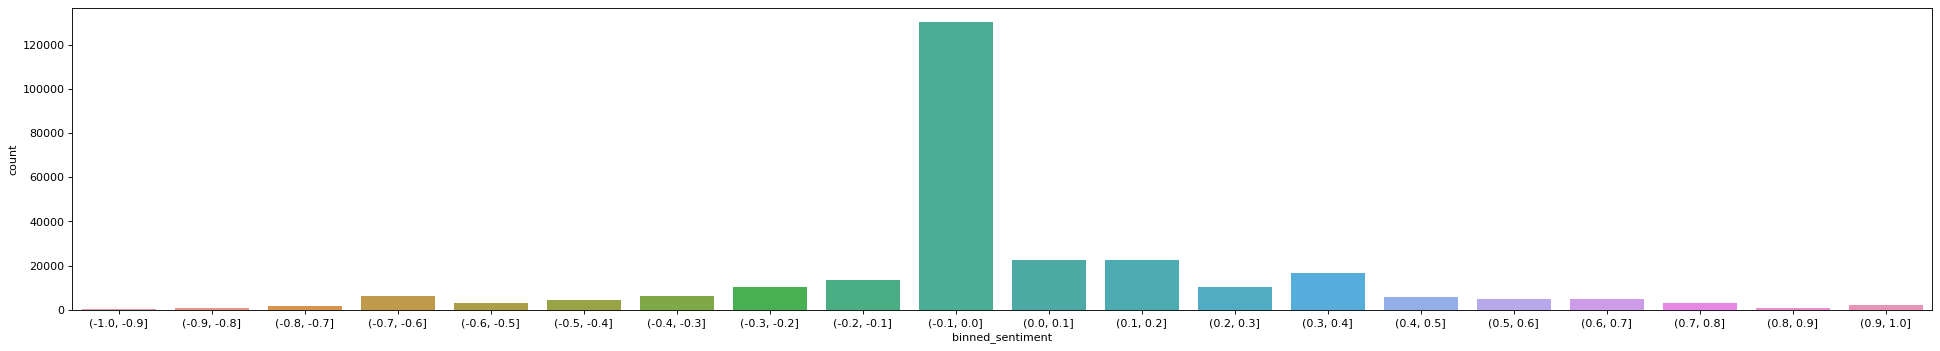

In [40]:
figure(num=None, figsize=(30, 5), dpi=80, facecolor='w', edgecolor='k')
sea.countplot(x = data_new['binned_sentiment'])

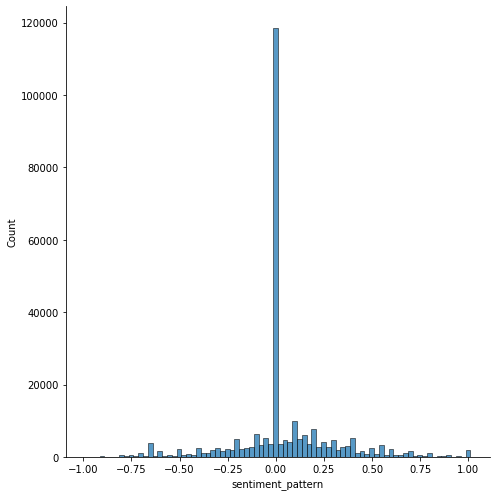

In [41]:
sea.displot(data_new, x='sentiment_pattern', binwidth=0.025, height = 7)

In [42]:
# data_use[data_use["sentiment_pattern"] >= 1.0]['processed_text']

In [43]:
positive_vocab = Counter()
for i in data_new[data_new["sentiment_pattern"] > 0]['processed_text']: 
    positive_vocab.update(i)

In [44]:
negative_vocab = Counter()
for i in data_new[data_new["sentiment_pattern"] < 0]['processed_text']: 
    negative_vocab.update(i)

In [45]:
#num positive tweets
print(data_new[data_new["sentiment_pattern"] > 0].shape[0])
#num negative tweets
print(data_new[data_new["sentiment_pattern"] < 0].shape[0])

93647
60048


In [46]:
positive_vocab.most_common(20)
df_pos = pd.DataFrame(positive_vocab.most_common(100),columns = ['WORD','FREQUENCY'])
df_neg = pd.DataFrame(negative_vocab.most_common(100),columns = ['WORD','FREQUENCY'])
df_dirty = pd.DataFrame(dirty_vocab.most_common(100),columns = ['WORD','FREQUENCY'])

df_neg['PERCENTAGE_TOTAL'] = df_neg['FREQUENCY']/60048
df_neg

,WORD,FREQUENCY,PERCENTAGE_TOTAL
0,corona,14777,0.246086
1,peopl,7116,0.118505
2,infect,4454,0.074174
3,coronaviru,4135,0.068862
4,still,2967,0.049410
...,...,...,...
95,caus,570,0.009492
96,believ,565,0.009409
97,concern,564,0.009392
98,almost,562,0.009359


In [47]:
df_pos['PERCENTAGE_TOTAL'] = df_pos['FREQUENCY']/93647
df_pos

,WORD,FREQUENCY,PERCENTAGE_TOTAL
0,corona,21578,0.230418
1,peopl,8343,0.089090
2,coronaviru,5209,0.055624
3,still,4127,0.044070
4,realli,3529,0.037684
...,...,...,...
95,around,894,0.009546
96,show,889,0.009493
97,beauti,888,0.009482
98,current,886,0.009461


In [48]:
df_dirty

,WORD,FREQUENCY
0,corona,57514
1,people,21702
2,coronavirus,19282
3,still,9992
4,virus,8941
...,...,...
95,close,1701
96,infection,1695
97,together,1687
98,total,1667


In [49]:
#evaluating popularity of words indicating depressive tendencies
depression_indicator_words = ['sad', 'depressed', 'worried', 'scared',
                              'afraid', 'nervous', 'anxious', 'depression',
                              'anxiety', 'angry', 'trauma', 'ill', 'sick', 
                              'chronic', 'abuse', 'tired', 'lonely', 'despair',
                              'illness', 'sickness', 'pain', 'painful', 'crisis',
                              'disaster']
for i in depression_indicator_words: 
    print(i, dirty_vocab[i])

sad 0
depressed 21
worried 344
scared 138
afraid 770
nervous 27
anxious 90
depression 44
anxiety 163
angry 396
trauma 29
ill 0
sick 0
chronic 169
abuse 341
tired 361
lonely 84
despair 11
illness 168
sickness 20
pain 0
painful 102
crisis 4085
disaster 336


In [50]:
for i in depression_indicator_words: 
    print(i, negative_vocab[i])

sad 16
depressed 0
worried 0
scared 0
afraid 559
nervous 3
anxious 6
depression 0
anxiety 0
angry 0
trauma 3
ill 57
sick 4
chronic 186
abuse 0
tired 0
lonely 0
despair 0
illness 0
sickness 0
pain 72
painful 0
crisis 0
disaster 0


In [51]:
for i in depression_indicator_words: 
    print(i, positive_vocab[i])

sad 12
depressed 0
worried 0
scared 0
afraid 151
nervous 2
anxious 0
depression 0
anxiety 0
angry 0
trauma 14
ill 100
sick 11
chronic 42
abuse 0
tired 0
lonely 0
despair 2
illness 0
sickness 0
pain 70
painful 0
crisis 0
disaster 0


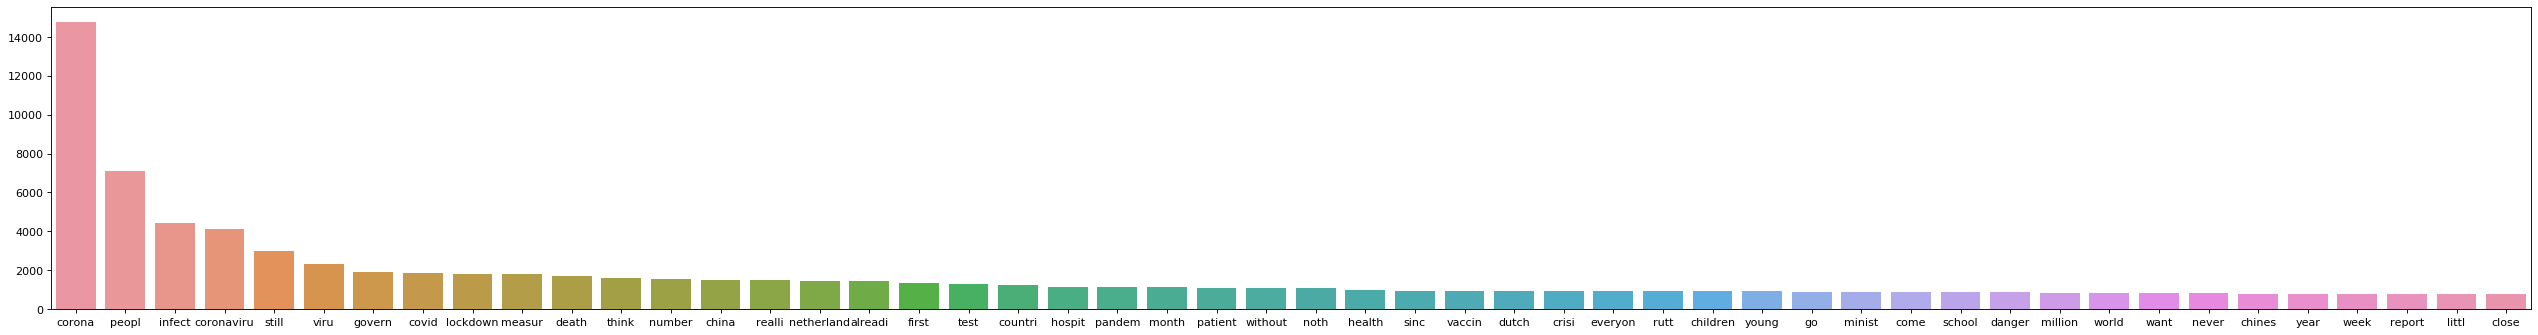

In [52]:
figure(num=None, figsize=(40, 5), dpi=80, facecolor='w', edgecolor='k')
sea.barplot(x = get_keys(negative_vocab.most_common(50)), y = get_vals(negative_vocab.most_common(50)))

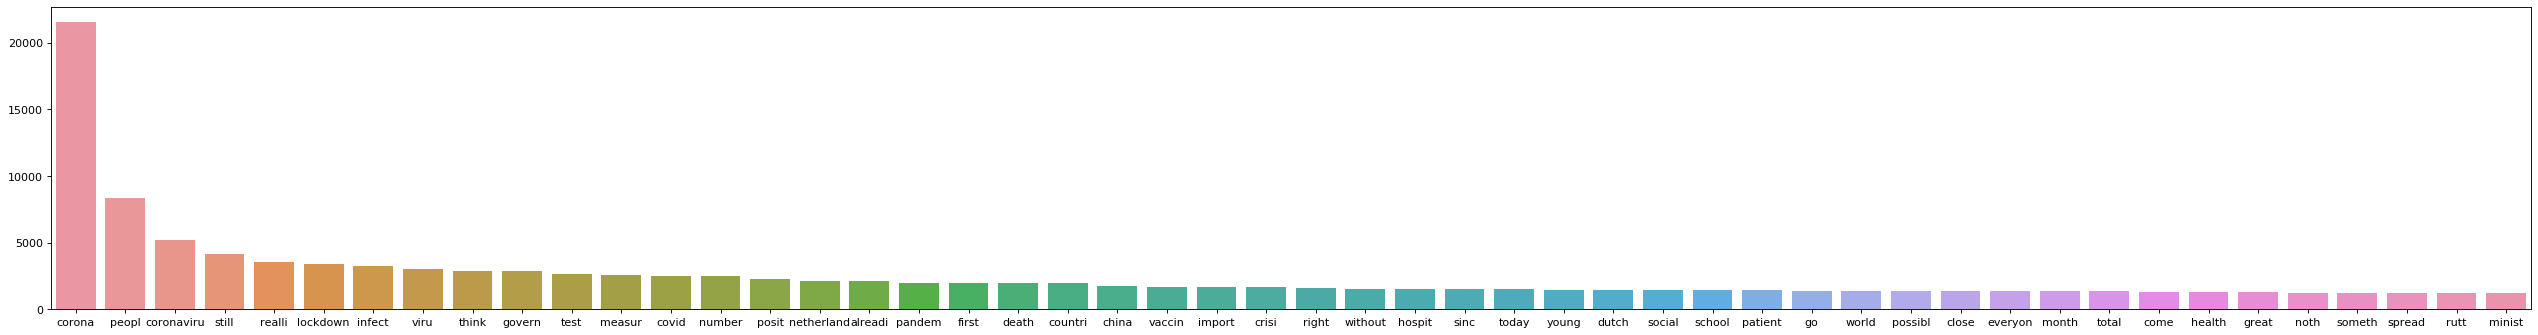

In [53]:
figure(num=None, figsize=(40, 5), dpi=80, facecolor='w', edgecolor='k')
sea.barplot(x = get_keys(positive_vocab.most_common(50)), y = get_vals(positive_vocab.most_common(50)))

## Classification 
Labels will be the sentiment_pattern from -1,1 generated by "pattern" package in python. 

In [54]:
labels = data_new['binned_sentiment_labels']
#generate the train-test split
train_docs = data_new['processed_text']
train_labels = to_categorical(labels)
X_train, X_test, y_train, y_test = train_test_split(train_docs, train_labels, test_size=0.25, random_state=42)

In [55]:
#create our tokenizer
tokenizer = create_tokenizer(X_train)
# define vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary size: %d' % vocab_size)
# calculate the maximum sequence length
max_length = 29
print('Maximum length: %d' % max_length)

Vocabulary size: 40070
Maximum length: 29


In [56]:
def encode_docs(tokenizer, max_length, docs): 
    # integer encode
    encoded = tokenizer.texts_to_sequences(docs) 
    # pad sequences
    print(len(encoded))
    padded = pad_sequences(encoded, maxlen=max_length, padding='post') 
    print(padded.shape)
    return padded

In [57]:
# encode data (basically this is adding padding to each vector)
Xtrain = encode_docs(tokenizer, max_length, X_train) 
# Xtrain = np.reshape(Xtrain, (len(Xtrain), max_length, embedding_dims))
Xtest = encode_docs(tokenizer, max_length, X_test) 
# print(Xtrain)

202990
(202990, 29)
67664
(67664, 29)


In [58]:
print(Xtrain.shape)
Xtrain = np.reshape(Xtrain, Xtrain.shape + (1,))
print(Xtrain.shape)
print(Xtest.shape)
Xtest = np.reshape(Xtest, Xtest.shape + (1,))
print(Xtest.shape)
print(y_train.shape)
print(y_test.shape)

(202990, 29)
(202990, 29, 1)
(67664, 29)
(67664, 29, 1)
(202990, 5)
(67664, 5)


In [71]:
num_epochs = 20

# model_variations = [['RNN', 'rmsprop', 0.2, 'categorical_crossentropy', 'mod1', num_bins], 
#                    ['RNN', 'adam', 0.2, 'categorical_crossentropy', 'mod2', num_bins], 
#                    ['RNN', 'rmsprop', 0.1, 'categorical_crossentropy', 'mod3', num_bins], 
#                    ['RNN', 'adam', 0.2, 'categorical_crossentropy', 'mod4', num_bins], 
#                    ['LSTM', 'rmsprop', 0.2, 'categorical_crossentropy', 'mod5', num_bins], 
#                    ['LSTM', 'rmsprop', 0.1, 'categorical_crossentropy', 'mod6', num_bins]]

model_variations = [['LSTM', 'rmsprop', 0.4, 'categorical_crossentropy', 'mod6', num_bins]]

#instantiation of results database to keep track of all results
res = {'Model_type': [''], 'Num_epochs':[0], 'Optimizer':['na'], 'Dropout':[0], 'Loss_func':['na'], 
           'Number_bins':[0], 'Training_acc':[0], 'Validation_acc':[0]}
results_df = pd.DataFrame(res)

def model_tuning(model_variations, results_df): 
    for i in model_variations: 
        if i[0] == 'RNN': 
            model = define_rnn(vocab_size, max_length, i[1], drop_percent = i[2], loss_func = i[3], model_name = i[4], num_bins = i[5])
        else:
            model = define_lstm(vocab_size, max_length, i[1], drop_percent = i[2], loss_func = i[3], model_name = i[4], num_bins = i[5])
        model.fit(Xtrain, y_train, batch_size = batch_size, epochs=num_epochs, verbose=2, validation_data = (Xtest, y_test))
        history_dict1 = model.history.history
        results_df = results_df.append({'Model_type': i[0], 'Num_epochs':num_epochs, 'Optimizer':i[1], 'Dropout':i[2],
                                    'Loss_func':'categorical_crossentropy', 'Number_bins':num_bins, 'Training_acc':history_dict1['acc'][-1], 'Validation_acc':history_dict1['val_acc'][-1]}, 
                                   ignore_index = True)
    return results_df, model
        

In [72]:
results_df, model = model_tuning(model_variations, results_df)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 29, 20)            1760      
_________________________________________________________________
dropout_8 (Dropout)          (None, 29, 20)            0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 580)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 2905      
Total params: 4,665
Trainable params: 4,665
Non-trainable params: 0
_________________________________________________________________
Train on 202990 samples, validate on 67664 samples
Epoch 1/20
202990/202990 - 139s - loss: 0.9887 - acc: 0.6965 - val_loss: 0.9734 - val_acc: 0.6979
Epoch 2/20
202990/202990 - 136s - loss: 0.9857 - acc: 0.6967 - val_loss: 0.9884 - val_acc: 0.6975
Epo

In [64]:
# results_df = results_df.append({'Num_epochs':num_epochs, 'Optimizer':'rmsprop', 'Dropout':0.2,
#                                     'Loss_func':'categorical_crossentropy', 'Number_bins':num_bins, 'Training_acc':[0], 'Validation_acc':[0]}, 
#                                    ignore_index = True)
# # define model
# model = define_lstm(vocab_size, max_length, 'rmsprop', drop_percent = 0.2, loss_func = 'categorical_crossentropy', model_name = 'mod1', num_bins = num_bins)
# # fit network
# model.fit(Xtrain, y_train, batch_size = batch_size, epochs=num_epochs, verbose=2, validation_data = (Xtest, y_test))
# # save the model
# # model.save('model.h5')

In [73]:
# model.history
results_df

,Model_type,Num_epochs,Optimizer,Dropout,Loss_func,Number_bins,Training_acc,Validation_acc
0,,0,na,0.0,na,0,0.000000,0.00000
1,LSTM,20,rmsprop,0.4,categorical_crossentropy,5,0.696226,0.69789


In [74]:
history_dict1 = model.history.history
history_dict1.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

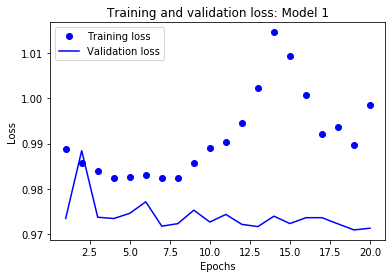

In [75]:
loss1 = plot_loss_metrics(history_dict1, 20, '1')
loss1.savefig('model1_loss.png')

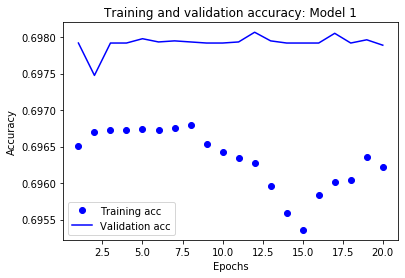

In [76]:
acc1 = plot_acc_metrics(history_dict1, 20, '1')
acc1.savefig('model1_acc.png')

In [ ]:
results_df

In [ ]:
# define model
model = define_model(vocab_size, max_length, 'adam', drop_percent = 0.1, loss_func = 'categorical_crossentropy', model_name = 'mod2', num_bins = num_bins)
# fit network
model.fit(Xtrain, y_train, batch_size = batch_size, epochs=num_epochs, verbose=2, validation_data = (Xtest, y_test))
# save the model
# model.save('model.h5')

In [ ]:
history_dict1 = model.history.history
history_dict1.keys()
# loss1 = plot_loss_metrics(history_dict1, 20, '1')
# loss1.savefig('model1_loss.png')

In [ ]:
results_df = results_df.append({'Num_epochs':num_epochs, 'Optimizer':'adam', 'Dropout':0.1,
                                    'Loss_func':'categorical_crossentropy', 'Number_bins':num_bins, 'Training_acc':history_dict1['acc'][-1], 'Validation_acc':history_dict1['val_acc'][-1]}, 
                                   ignore_index = True)

In [ ]:
acc1 = plot_acc_metrics(history_dict1, 20, '1')
acc1.savefig('model1_acc.png')

In [ ]:
results_df